In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.graph_objects as go
import datetime


In [3]:
ticker = "ME8U.SI"
start_date = "2015-01-01"
end_date = "2025-03-16"

df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [4]:
df

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,ME8U.SI,ME8U.SI,ME8U.SI,ME8U.SI,ME8U.SI,ME8U.SI
Date,,,,,,
2015-01-02,0.820872,1.489986,1.494969,1.480019,1.485002,1100691
2015-01-05,0.823617,1.494969,1.494969,1.480019,1.489986,1635484
2015-01-06,0.823617,1.494969,1.494969,1.480019,1.489986,2580654
2015-01-07,0.823617,1.494969,1.499952,1.489986,1.494969,1149856
2015-01-08,0.834599,1.514902,1.514902,1.494969,1.494969,2339847
...,...,...,...,...,...,...
2025-03-10,2.020000,2.020000,2.030000,2.000000,2.000000,9382900
2025-03-11,2.040000,2.040000,2.050000,2.000000,2.010000,16492300


In [5]:
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

In [6]:
df

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,0.820872,1.489986,1.494969,1.480019,1.485002,1100691
2015-01-05,0.823617,1.494969,1.494969,1.480019,1.489986,1635484
2015-01-06,0.823617,1.494969,1.494969,1.480019,1.489986,2580654
2015-01-07,0.823617,1.494969,1.499952,1.489986,1.494969,1149856
2015-01-08,0.834599,1.514902,1.514902,1.494969,1.494969,2339847
...,...,...,...,...,...,...
2025-03-10,2.020000,2.020000,2.030000,2.000000,2.000000,9382900
2025-03-11,2.040000,2.040000,2.050000,2.000000,2.010000,16492300
2025-03-12,2.060000,2.060000,2.090000,2.030000,2.040000,19105000


In [7]:
df = df.rename(columns={'Close': 'GT'})
df

Price,Adj Close,GT,High,Low,Open,Volume
Date,,,,,,
2015-01-02,0.820872,1.489986,1.494969,1.480019,1.485002,1100691
2015-01-05,0.823617,1.494969,1.494969,1.480019,1.489986,1635484
2015-01-06,0.823617,1.494969,1.494969,1.480019,1.489986,2580654
2015-01-07,0.823617,1.494969,1.499952,1.489986,1.494969,1149856
2015-01-08,0.834599,1.514902,1.514902,1.494969,1.494969,2339847
...,...,...,...,...,...,...
2025-03-10,2.020000,2.020000,2.030000,2.000000,2.000000,9382900
2025-03-11,2.040000,2.040000,2.050000,2.000000,2.010000,16492300
2025-03-12,2.060000,2.060000,2.090000,2.030000,2.040000,19105000


In [8]:
print(df['GT'].dtypes)
print(df['GT'].describe())


float64
count    2561.000000
mean        2.192746
std         0.447824
min         1.370388
25%         1.833829
50%         2.210000
75%         2.530000
max         3.338765
Name: GT, dtype: float64


### Visualize Data

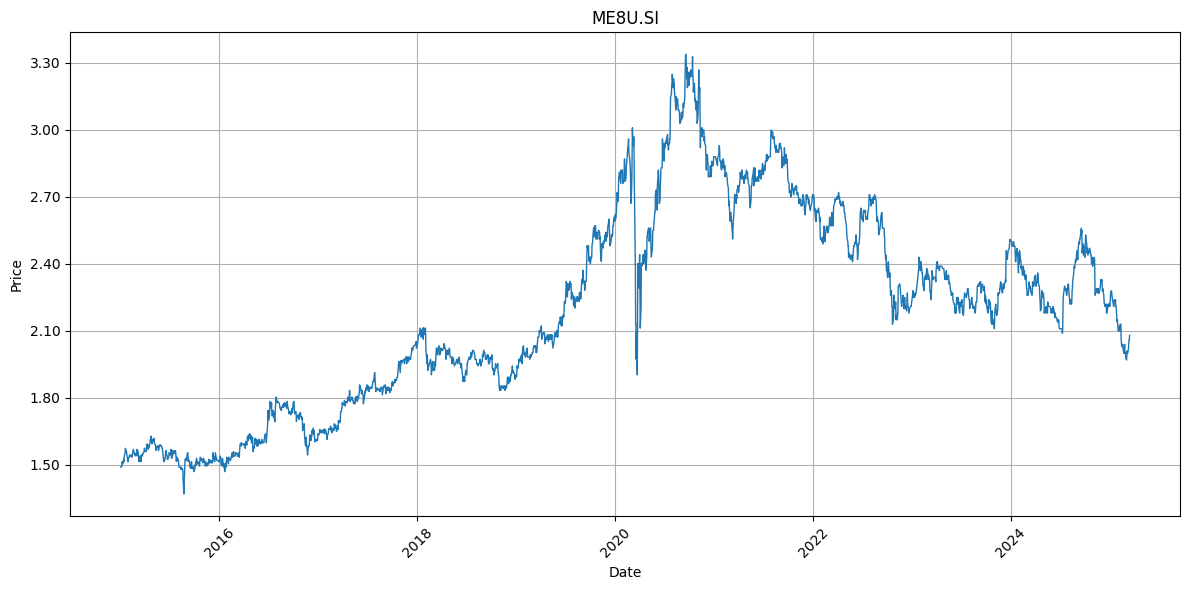

In [9]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['GT'], linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ME8U.SI')

# Format y-axis ticks to 2 decimal places
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

# Automatically reduce number of y-axis ticks (matplotlib does it smartly)
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=8))  # Limit to ~8 y-axis ticks

# Rotate x-axis ticks to avoid overlap
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



## Standardize data 

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(df['GT'].values.reshape(-1,1))
scaled_prices

array([[0.06075966],
       [0.06329122],
       [0.06329122],
       ...,
       [0.35034547],
       [0.35034547],
       [0.36050611]], shape=(2561, 1))

## Construct datasets

In [11]:
MOVING_WINDOW = 60
all_x, all_y = [], []
for i in range(len(scaled_prices) - MOVING_WINDOW):
    all_x.append(scaled_prices[i:i+MOVING_WINDOW]) #first 60 price
    all_y.append(scaled_prices[i+MOVING_WINDOW]) #61st price

all_x = np.array(all_x)
all_y = np.array(all_y)

In [12]:
all_x.shape, all_y.shape

((2501, 60, 1), (2501, 1))

## Split dataset

In [13]:
DS_SPLIT = 0.8

train_ds_size = round(all_x.shape[0] * DS_SPLIT)
train_x, train_y = all_x[:train_ds_size], all_y[:train_ds_size]
test_x, test_y = all_x[train_ds_size:], all_y[train_ds_size:]

In [14]:
train_x.shape

(2001, 60, 1)

In [15]:
train_y.shape

(2001, 1)

In [16]:
test_x.shape

(500, 60, 1)

In [17]:
test_y.shape

(500, 1)

## Construct Model

In [ ]:
'''
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_x.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()
'''

c:\Users\Jesus\anaconda3\envs\lstm\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
'''
model.compile(optimizer='adam', loss='mean_squared_error')
'''

## Train Model

In [138]:
'''
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(train_x, train_y,
          validation_split=0.2,
          callbacks=[callback],
          epochs=200)

model.save('me8u.keras')
'''

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0433 - val_loss: 9.7792e-04
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 8.6151e-04
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.0105e-04 - val_loss: 0.0017
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.4078e-04 - val_loss: 9.8158e-04
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - val_loss: 7.4675e-04
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011 - val_loss: 6.5148e-04
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.7171e-04 - val_loss: 6.9344e-04
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - val_loss: 7.9036e-04
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.5725e-04 - val_loss: 5.6653e-04
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.4684e-04 - val_loss: 7.6204e

In [18]:
model = load_model('me8u.keras')
preds = model.predict(test_x)
preds

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[0.5067704 ],
       [0.5077377 ],
       [0.49170676],
       [0.48568156],
       [0.4887249 ],
       [0.490323  ],
       [0.49113742],
       [0.4917293 ],
       [0.49225536],
       [0.48851404],
       [0.48362327],
       [0.5039872 ],
       [0.52701694],
       [0.5312648 ],
       [0.5296516 ],
       [0.51471525],
       [0.51062375],
       [0.51512283],
       [0.5086456 ],
       [0.51180583],
       [0.5178181 ],
       [0.5194623 ],
       [0.51945776],
       [0.5190916 ],
       [0.5187482 ],
       [0.5184996 ],
       [0.51400334],
       [0.5128903 ],
       [0.51296484],
       [0.5132072 ],
       [0.51334924],
       [0.49618524],
       [0.48779404],
       [0.49567956],
       [0.49468675],
       [0.5070646 ],
       [0.49305722],
       [0.48833367],
       [0.48766333],
       [0.48794988],
       [0.4966542 ],
       [0.49888593],
       [0.49020165],
       [0.47903427],
       [0.4808058 ],
       [0.47408137],
       [0.46442664],
       [0.462

In [19]:
preds = scaler.inverse_transform(preds) #convert back to original scale
preds

array([[2.367903 ],
       [2.3698072],
       [2.338252 ],
       [2.3263924],
       [2.332383 ],
       [2.3355286],
       [2.3371315],
       [2.3382964],
       [2.339332 ],
       [2.3319678],
       [2.322341 ],
       [2.3624249],
       [2.407756 ],
       [2.4161172],
       [2.412942 ],
       [2.3835418],
       [2.375488 ],
       [2.3843439],
       [2.3715944],
       [2.3778148],
       [2.3896492],
       [2.3928857],
       [2.3928769],
       [2.392156 ],
       [2.3914802],
       [2.3909907],
       [2.3821404],
       [2.3799496],
       [2.3800962],
       [2.3805733],
       [2.380853 ],
       [2.3470676],
       [2.3305504],
       [2.3460722],
       [2.3441179],
       [2.368482 ],
       [2.3409104],
       [2.3316128],
       [2.3302934],
       [2.3308573],
       [2.3479908],
       [2.3523836],
       [2.3352897],
       [2.313308 ],
       [2.316795 ],
       [2.3035588],
       [2.2845547],
       [2.2811222],
       [2.2825181],
       [2.2679775],


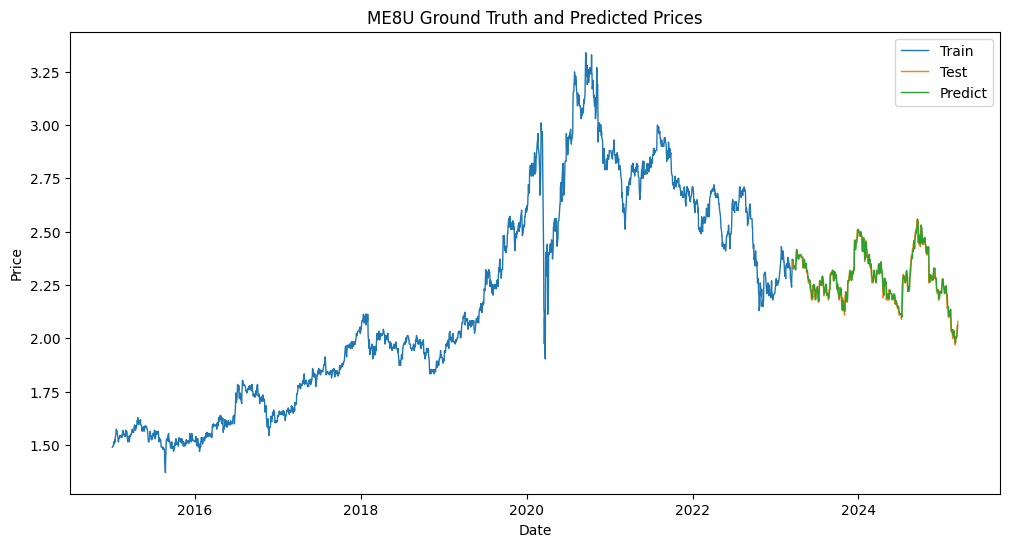

In [20]:
train_df = df[:train_ds_size+MOVING_WINDOW]
test_df = df[train_ds_size+MOVING_WINDOW:]
test_df = test_df.assign(Predict = preds)
plt.figure(figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train_df["GT"], linewidth=1)
plt.plot(test_df["GT"], linewidth=1)
plt.plot(test_df["Predict"], linewidth=1)
plt.legend(["Train", "Test", "Predict"])
plt.title("ME8U Ground Truth and Predicted Prices")
plt.show()

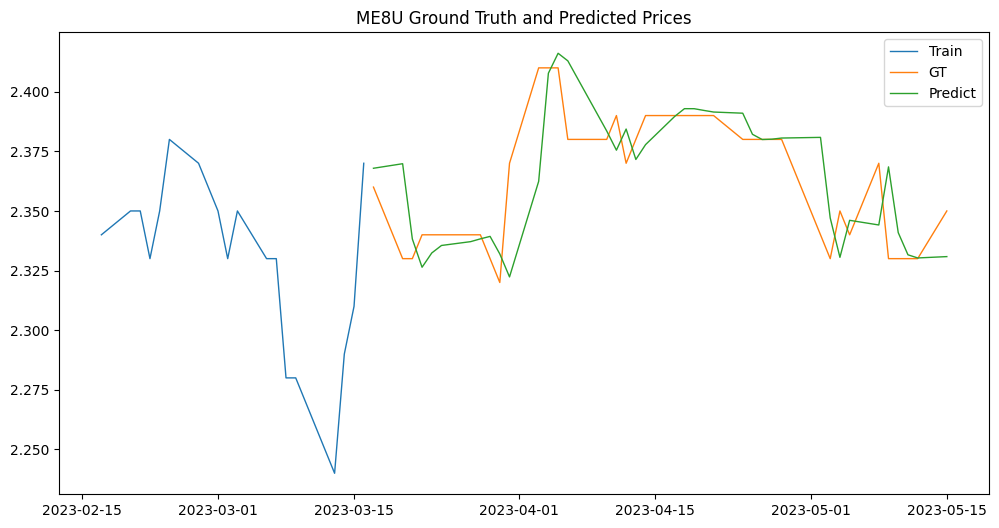

In [21]:
#zoom in
plt.figure(figsize=(12, 6))
plt.plot(train_df["GT"][-20:], linewidth=1)
plt.plot(test_df["GT"][:40], linewidth=1)
plt.plot(test_df["Predict"][:40], linewidth=1)
plt.legend(["Train", "GT", "Predict"])
plt.title("ME8U Ground Truth and Predicted Prices")
plt.show()

In [31]:
y_true = test_df["GT"]
y_pred = test_df["Predict"]

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R-squared (R²): {r2:.6f}")

Mean Absolute Error (MAE): 0.018273
Mean Squared Error (MSE): 0.000592
Root Mean Squared Error (RMSE): 0.024335
R-squared (R²): 0.956065


In [23]:
test_df

Price,Adj Close,GT,High,Low,Open,Volume,Predict
Date,,,,,,,
2023-03-17,2.09568,2.36,2.38,2.34,2.37,5907400,2.367903
2023-03-20,2.06904,2.33,2.36,2.30,2.36,3351367,2.369807
2023-03-21,2.06904,2.33,2.36,2.33,2.34,3885000,2.338252
2023-03-22,2.07792,2.34,2.35,2.31,2.34,5993900,2.326392
2023-03-23,2.07792,2.34,2.36,2.31,2.32,5157700,2.332383
...,...,...,...,...,...,...,...
2025-03-10,2.02000,2.02,2.03,2.00,2.00,9382900,2.005775
2025-03-11,2.04000,2.04,2.05,2.00,2.01,16492300,2.017598
2025-03-12,2.06000,2.06,2.09,2.03,2.04,19105000,2.035653


In [28]:
test_df['GT_tmr'] = test_df['GT'].shift(1)
test_df.dropna(subset=['GT_tmr'], inplace=True)

test_df

Price,Adj Close,GT,High,Low,Open,Volume,Predict,GT_tmr
Date,,,,,,,,
2023-03-21,2.06904,2.33,2.36,2.33,2.34,3885000,2.338252,2.33
2023-03-22,2.07792,2.34,2.35,2.31,2.34,5993900,2.326392,2.33
2023-03-23,2.07792,2.34,2.36,2.31,2.32,5157700,2.332383,2.34
2023-03-24,2.07792,2.34,2.36,2.32,2.34,5930700,2.335529,2.34
2023-03-27,2.07792,2.34,2.39,2.34,2.37,5270500,2.337132,2.34
...,...,...,...,...,...,...,...,...
2025-03-07,2.00000,2.00,2.00,1.99,2.00,4183000,2.007431,2.00
2025-03-10,2.02000,2.02,2.03,2.00,2.00,9382900,2.005775,2.00
2025-03-11,2.04000,2.04,2.05,2.00,2.01,16492300,2.017598,2.02


In [30]:
results = {}

# Loop through the prediction columns
for col in ["Predict", "GT_tmr"]:
    y_true = test_df["GT"]
    y_pred = test_df[col]

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    results[col] = [mae, mse, rmse, r2]

# Convert to DataFrame for a clean display
metrics_df = pd.DataFrame(results, index=["MAE", "MSE", "RMSE", "R2"])
print(metrics_df)

       Predict    GT_tmr
MAE   0.018273  0.016962
MSE   0.000592  0.000547
RMSE  0.024335  0.023398
R2    0.956065  0.959381


## Next-Day Predictive Trading Strategy

In [145]:
# Parameters
initial_capital = 10000
percent_of_equity = 0.8
stop_loss = 0.1  
capital = initial_capital
position = None  
entry_price = 0  
equity = initial_capital  
trade_log = [] 

# Iterate through the DataFrame
for i in range(1, len(test_df) - 1): 
    current_price = test_df['GT'].iloc[i]  # Ground truth
    next_predicted_price = test_df['Predict'].iloc[i + 1]  # Predicted price 
    date = test_df.index[i] 

    # Check if a position is active
    if position == 'long':
        # Check for stop-loss or trend reversal
        if current_price <= entry_price * (1 - stop_loss) or next_predicted_price < current_price:
            # Close long position
            profit = (current_price - entry_price) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({'Date': date, 'Action': 'Close Long', 'Price': current_price, 'Profit': profit, 'Equity': equity})
            position = None

    elif position == 'short':
        # Check for stop-loss or trend reversal
        if current_price >= entry_price * (1 + stop_loss) or next_predicted_price > current_price:
            # Close short position
            profit = (entry_price - current_price) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({'Date': date, 'Action': 'Close Short', 'Price': current_price, 'Profit': profit, 'Equity': equity})
            position = None

    # If no position is active, check for entry signals
    if position is None:
        if next_predicted_price > current_price:
            # Open long position
            entry_price = current_price
            position = 'long'
            trade_log.append({'Date': date, 'Action': 'Open Long', 'Price': current_price, 'Profit': 0, 'Equity': equity})
        elif next_predicted_price < current_price:
            # Open short position
            entry_price = current_price
            position = 'short'
            trade_log.append({'Date': date, 'Action': 'Open Short', 'Price': current_price, 'Profit': 0, 'Equity': equity})


trade_log_df = pd.DataFrame(trade_log)

# Calculate metrics
closed_trades = trade_log_df[trade_log_df['Action'].str.contains('Close')]  
gross_profit = closed_trades[closed_trades['Profit'] > 0]['Profit'].sum()  
gross_loss = closed_trades[closed_trades['Profit'] < 0]['Profit'].sum()  
net_profit = gross_profit + gross_loss  

# Buy-and-Hold Return
initial_price = test_df['GT'].iloc[0] 
final_price = test_df['GT'].iloc[-1] 
buy_and_hold_return = ((final_price - initial_price) / initial_price) * 100  

# Display results
print(f"Gross Profit: ${gross_profit:.2f}")
print(f"Gross Loss: ${gross_loss:.2f}")
print(f"Net Profit: ${net_profit:.2f}")
print(f"Buy-and-Hold Return: {buy_and_hold_return:.2f}%")

# Display the trade log
print(trade_log_df)

# Final equity
print(f"Final Equity: ${equity:.2f}")

Gross Profit: $9170.02
Gross Loss: $-8556.11
Net Profit: $613.91
Buy-and-Hold Return: -11.86%
          Date       Action  Price      Profit        Equity
0   2023-03-20    Open Long   2.33    0.000000  10000.000000
1   2023-03-21   Close Long   2.33    0.000000  10000.000000
2   2023-03-21   Open Short   2.33    0.000000  10000.000000
3   2023-03-29  Close Short   2.33    0.000000  10000.000000
4   2023-03-29    Open Long   2.33    0.000000  10000.000000
..         ...          ...    ...         ...           ...
376 2025-03-06    Open Long   2.00    0.000000  10692.322128
377 2025-03-10   Close Long   2.02   79.999924  10772.322052
378 2025-03-10   Open Short   2.02    0.000000  10772.322052
379 2025-03-13  Close Short   2.06 -158.415692  10613.906360
380 2025-03-13    Open Long   2.06    0.000000  10613.906360

[381 rows x 5 columns]
Final Equity: $10613.91


In [146]:
# Extract series
dates = test_df.index
gt = test_df['GT']
predict = test_df['Predict']

# Separate long/short entries & exits from the trade log
entry_long = trade_log_df[trade_log_df['Action'].str.contains("Open Long")]
entry_short = trade_log_df[trade_log_df['Action'].str.contains("Open Short")]
exit_long = trade_log_df[trade_log_df['Action'].str.contains("Close Long")]
exit_short = trade_log_df[trade_log_df['Action'].str.contains("Close Short")]

# Create the interactive plot
fig = go.Figure()

# Ground truth price line
fig.add_trace(go.Scatter(x=dates, y=gt, mode='lines', name='GT (Actual)', line=dict(color='blue')))

# Predicted price line
fig.add_trace(go.Scatter(x=dates, y=predict, mode='lines', name='Predicted', line=dict(color='orange')))

# Entry Long signals
fig.add_trace(go.Scatter(
    x=entry_long['Date'], y=entry_long['Price'],
    mode='markers',
    name='Buy Signal',
    marker=dict(symbol='triangle-up', size=10, color='green')
))

# Entry Short signals
fig.add_trace(go.Scatter(
    x=entry_short['Date'], y=entry_short['Price'],
    mode='markers',
    name='Sell Signal',
    marker=dict(symbol='triangle-down', size=10, color='red')
))

# Exit Long signals
fig.add_trace(go.Scatter(
    x=exit_long['Date'], y=exit_long['Price'],
    mode='markers',
    name='Exit Long',
    marker=dict(symbol='x', size=9, color='lime')
))

# Exit Short signals
fig.add_trace(go.Scatter(
    x=exit_short['Date'], y=exit_short['Price'],
    mode='markers',
    name='Exit Short',
    marker=dict(symbol='x', size=9, color='purple')
))

# Layout settings
fig.update_layout(
    title='Next-Day Predictive Trading Strategy',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    template='plotly_white',
    hovermode='closest'
)

fig.show()


## Append news analysis result

In [147]:
sentiment_df = pd.read_csv('../news_analysis_code/me8u_news_data.csv', usecols=['date', 'sentiment', 'sentiment_score'])
sentiment_df.columns = ['Date', 'Sentiment', 'Sentiment Score']
sentiment_df.head()

,Date,Sentiment,Sentiment Score
0,2025-02-19,positive,0.944809
1,2025-02-19,negative,0.945574
2,2024-12-09,neutral,0.836522
3,2025-03-05,negative,0.940697
4,2025-03-12,neutral,0.942091


In [148]:
# rearrange the date
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

# Keep only the row with the highest sentiment score
sentiment_df = sentiment_df.loc[sentiment_df.groupby('Date')['Sentiment Score'].idxmax()].reset_index(drop=True)

sentiment_df.head()

,Date,Sentiment,Sentiment Score
0,2010-10-11,neutral,0.901061
1,2014-02-20,positive,0.644854
2,2014-08-04,negative,0.683566
3,2016-06-30,neutral,0.942887
4,2016-07-01,positive,0.949793


In [149]:
sentiment_df['Sentiment'] = sentiment_df['Sentiment'].replace({
    'neutral': 0,
    'positive': 1,
    'negative': -1
})

sentiment_df.head()

C:\Users\Jesus\AppData\Local\Temp\ipykernel_18800\1101630648.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,Date,Sentiment,Sentiment Score
0,2010-10-11,0,0.901061
1,2014-02-20,1,0.644854
2,2014-08-04,-1,0.683566
3,2016-06-30,0,0.942887
4,2016-07-01,1,0.949793


In [150]:
sentiment_df.dtypes

Date               datetime64[ns]
Sentiment                   int64
Sentiment Score           float64
dtype: object

In [151]:
sentiment_df = sentiment_df.set_index('Date')

In [152]:
#keep only matching dates
merged_df = pd.merge(test_df, sentiment_df, on='Date', how='left')
merged_df.head()

,Adj Close,GT,High,Low,Open,Volume,Predict,Sentiment,Sentiment Score
Date,,,,,,,,,
2023-03-17,2.09568,2.36,2.38,2.34,2.37,5907400,2.367903,NaN,NaN
2023-03-20,2.06904,2.33,2.36,2.30,2.36,3351367,2.369807,NaN,NaN
2023-03-21,2.06904,2.33,2.36,2.33,2.34,3885000,2.338252,NaN,NaN
2023-03-22,2.07792,2.34,2.35,2.31,2.34,5993900,2.326392,NaN,NaN
2023-03-23,2.07792,2.34,2.36,2.31,2.32,5157700,2.332383,NaN,NaN


In [153]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2023-03-17 to 2025-03-14
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Adj Close        500 non-null    float64
 1   GT               500 non-null    float64
 2   High             500 non-null    float64
 3   Low              500 non-null    float64
 4   Open             500 non-null    float64
 5   Volume           500 non-null    int64  
 6   Predict          500 non-null    float32
 7   Sentiment        84 non-null     float64
 8   Sentiment Score  84 non-null     float64
dtypes: float32(1), float64(7), int64(1)
memory usage: 37.1 KB


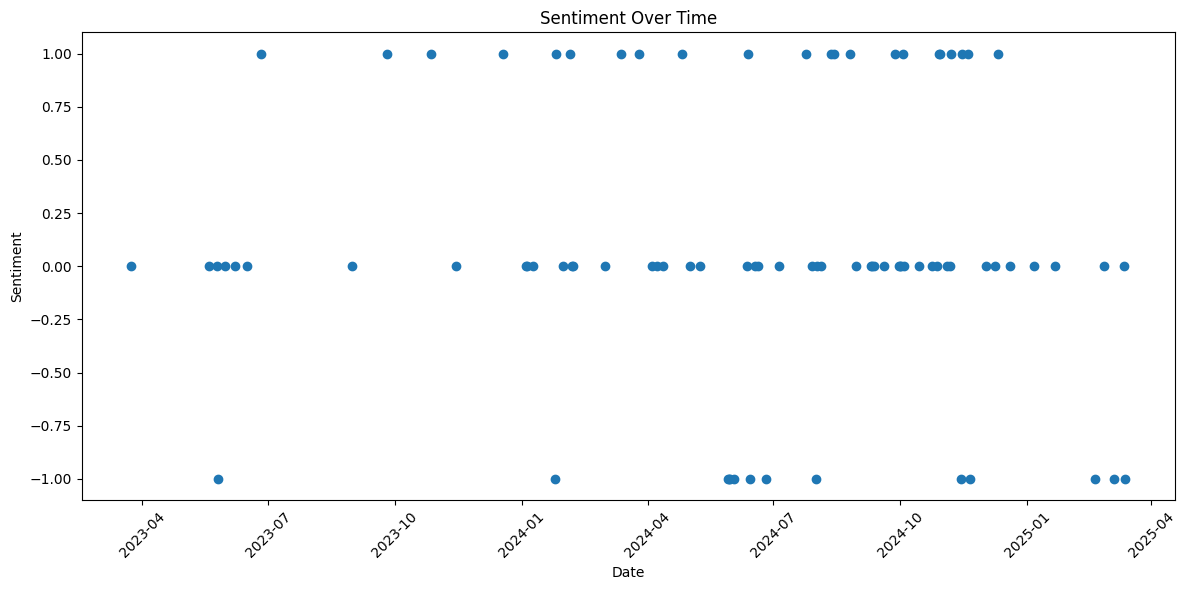

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(merged_df['Sentiment'], marker='o', linestyle='None')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Sentiment Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

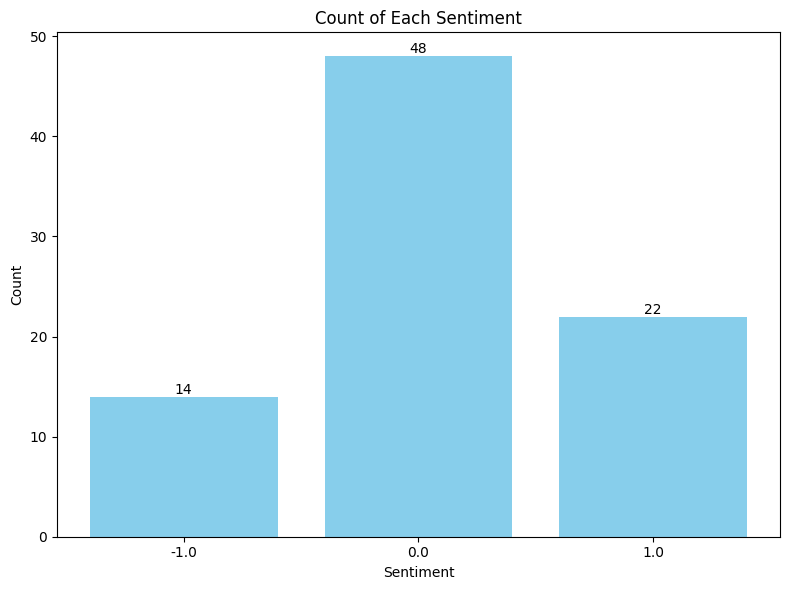

In [155]:
sentiment_counts = merged_df['Sentiment'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
bars = plt.bar(sentiment_counts.index.astype(str), sentiment_counts.values, color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of Each Sentiment')

# Add the count above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)),
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [156]:
nan_count = merged_df['Sentiment'].isna().sum()
nan_count

np.int64(416)

In [157]:
merged_df

,Adj Close,GT,High,Low,Open,Volume,Predict,Sentiment,Sentiment Score
Date,,,,,,,,,
2023-03-17,2.09568,2.36,2.38,2.34,2.37,5907400,2.367903,NaN,NaN
2023-03-20,2.06904,2.33,2.36,2.30,2.36,3351367,2.369807,NaN,NaN
2023-03-21,2.06904,2.33,2.36,2.33,2.34,3885000,2.338252,NaN,NaN
2023-03-22,2.07792,2.34,2.35,2.31,2.34,5993900,2.326392,NaN,NaN
2023-03-23,2.07792,2.34,2.36,2.31,2.32,5157700,2.332383,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-03-10,2.02000,2.02,2.03,2.00,2.00,9382900,2.005775,NaN,NaN
2025-03-11,2.04000,2.04,2.05,2.00,2.01,16492300,2.017598,NaN,NaN
2025-03-12,2.06000,2.06,2.09,2.03,2.04,19105000,2.035653,0.0,0.942091


## News-Driven Next-Day Predictive Trading Strategy

In [158]:
initial_capital = 10000
percent_of_equity = 0.8
stop_loss = 0.2

capital = initial_capital
equity = initial_capital
trade_log = []
position = None
entry_price = None

i = 0
while i < len(test_df):
    # Forced exit condition on March 14, 2025
    if merged_df.index[i] == pd.Timestamp("2025-03-14"):
        if position is not None:
            exec_price = test_df['GT'].iloc[i]
            if position == 'long':
                profit = (exec_price - entry_price) * (capital * percent_of_equity / entry_price)
                trade_log.append({
                    'Date': test_df.index[i],
                    'Action': 'Forced Exit Long',
                    'Price': exec_price,
                    'Profit': profit,
                    'Equity': equity
                })
            elif position == 'short':
                profit = (entry_price - exec_price) * (capital * percent_of_equity / entry_price)
                trade_log.append({
                    'Date': test_df.index[i],
                    'Action': 'Forced Exit Short',
                    'Price': exec_price,
                    'Profit': profit,
                    'Equity': equity
                })
        break

    signal_price = merged_df['GT'].iloc[i]
    predicted_price = merged_df['Predict'].iloc[i]

    # Entry signals (same day)
    if position is None:
        if predicted_price > signal_price and (merged_df['Sentiment'].iloc[i] in [1, 0] or pd.isna(merged_df['Sentiment'].iloc[i])):
            position = 'long'
            entry_price = merged_df['GT'].iloc[i]
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Enter Long',
                'Price': entry_price,
                'Profit': 0,
                'Equity': equity
            })
        elif predicted_price < signal_price and (merged_df['Sentiment'].iloc[i] in [-1, 0] or pd.isna(merged_df['Sentiment'].iloc[i])):
            position = 'short'
            entry_price = merged_df['GT'].iloc[i]
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Enter Short',
                'Price': entry_price,
                'Profit': 0,
                'Equity': equity
            })
        i += 1
        continue

    # Exit conditions (same day)
    current_gt = merged_df['GT'].iloc[i]
    if position == 'long':
        if predicted_price < current_gt or current_gt <= entry_price * (1 - stop_loss) or merged_df['Sentiment'].iloc[i] == -1:
            profit = (current_gt - entry_price) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Exit Long',
                'Price': current_gt,
                'Profit': profit,
                'Equity': equity
            })
            position = None
    elif position == 'short':
        if predicted_price > current_gt or current_gt >= entry_price * (1 + stop_loss) or merged_df['Sentiment'].iloc[i] == 1:
            profit = (entry_price - current_gt) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Exit Short',
                'Price': current_gt,
                'Profit': profit,
                'Equity': equity
            })
            position = None
    i += 1

# Create DataFrame from trade log
trade_log_df = pd.DataFrame(trade_log)

# Summary metrics
closed_trades = trade_log_df[trade_log_df['Action'].str.contains('Exit')]
gross_profit = closed_trades[closed_trades['Profit'] > 0]['Profit'].sum()
gross_loss = closed_trades[closed_trades['Profit'] < 0]['Profit'].sum()
net_profit = gross_profit + gross_loss
buy_and_hold_return = ((test_df['GT'].iloc[-1] - test_df['GT'].iloc[0]) / test_df['GT'].iloc[0]) * 100

print(f"\n--- Strategy Summary ---")
print(f"Gross Profit: ${gross_profit:.2f}")
print(f"Gross Loss: ${gross_loss:.2f}")
print(f"Net Profit: ${net_profit:.2f}")
print(f"Buy-and-Hold Return: {buy_and_hold_return:.2f}%")
print(f"Final Equity: ${equity:.2f}")
print("\nTrade Log:")
print(trade_log_df)



--- Strategy Summary ---
Gross Profit: $6091.71
Gross Loss: $-6250.90
Net Profit: $-159.19
Buy-and-Hold Return: -11.86%
Final Equity: $9997.67

Trade Log:
          Date             Action  Price      Profit        Equity
0   2023-03-17         Enter Long   2.36    0.000000  10000.000000
1   2023-03-22          Exit Long   2.34  -67.796549   9932.203451
2   2023-03-23        Enter Short   2.34    0.000000   9932.203451
3   2023-03-29         Exit Short   2.33   34.188003   9966.391454
4   2023-03-30         Enter Long   2.32    0.000000   9966.391454
..         ...                ...    ...         ...           ...
287 2025-03-06         Exit Short   2.00   39.800957   9917.668332
288 2025-03-07         Enter Long   2.00    0.000000   9917.668332
289 2025-03-10          Exit Long   2.02   79.999924   9997.668256
290 2025-03-11        Enter Short   2.04    0.000000   9997.668256
291 2025-03-14  Forced Exit Short   2.08 -156.862598   9997.668256

[292 rows x 5 columns]


In [159]:
import plotly.graph_objects as go

# Extract series
dates = merged_df.index
gt = merged_df['GT']
predict = merged_df['Predict']

# Separate long/short entries & exits from the trade log
entry_long = trade_log_df[trade_log_df['Action'].str.contains("Enter Long")]
entry_short = trade_log_df[trade_log_df['Action'].str.contains("Enter Short")]
exit_long = trade_log_df[trade_log_df['Action'].str.contains("Exit Long")]
exit_short = trade_log_df[trade_log_df['Action'].str.contains("Exit Short")]

# Create the interactive plot
fig = go.Figure()

# Ground truth price line
fig.add_trace(go.Scatter(x=dates, y=gt, mode='lines', name='GT (Actual)', line=dict(color='blue')))

# Predicted price line
fig.add_trace(go.Scatter(x=dates, y=predict, mode='lines', name='Predicted', line=dict(color='orange')))

# Entry Long signals
fig.add_trace(go.Scatter(
    x=entry_long['Date'], y=entry_long['Price'],
    mode='markers',
    name='Buy Signal',
    marker=dict(symbol='triangle-up', size=10, color='green')
))

# Entry Short signals
fig.add_trace(go.Scatter(
    x=entry_short['Date'], y=entry_short['Price'],
    mode='markers',
    name='Sell Signal',
    marker=dict(symbol='triangle-down', size=10, color='red')
))

# Exit Long signals
fig.add_trace(go.Scatter(
    x=exit_long['Date'], y=exit_long['Price'],
    mode='markers',
    name='Exit Long',
    marker=dict(symbol='x', size=9, color='lime')
))

# Exit Short signals
fig.add_trace(go.Scatter(
    x=exit_short['Date'], y=exit_short['Price'],
    mode='markers',
    name='Exit Short',
    marker=dict(symbol='x', size=9, color='purple')
))

# Layout settings
fig.update_layout(
    title='News-Driven Next-Day Predictive Trading Strategy',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    template='plotly_white',
    hovermode='closest'
)

fig.show()
